# Predict stroke

Based on the [Stroke-Prediction-Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) from Kaggle.

This dataset is quite interesting since it has a big imbalance, almost 72% of the data are non-stroke outcomes.

In [2]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    %autoreload 2
    %matplotlib inline
    extensions_loaded = True

%reload_ext autoreload

In [3]:
import matplotlib.pyplot as plt
import so_ml_tools as soml
import tensorflow as tf
import sklearn as sk
import keras as ks
import pandas as pd
import numpy as np
import seaborn as sns
import shap as sh
import sweetviz as sv

from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline

2024-01-15 11:01:59.206010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 11:01:59.206031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 11:01:59.206621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
ALL_DATA_CSV = 'data/healthcare-dataset-stroke-data.csv'

In [207]:
all_data = pd.read_csv(ALL_DATA_CSV)
all_data.head().T

,0,1,2,3,4
id,9046,51676,31112,60182,1665
gender,Male,Female,Male,Female,Female
age,67.0,61.0,80.0,49.0,79.0
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.6,NaN,32.5,34.4,24.0


# Drop ID column

In [6]:
soml.pd.dataframe.drop_columns(dataframe=all_data, column_names=['id'])

# Check data quality

Some things that can stand out or might be interesting for observation:

1. Check the Null values column, null values can cause issues when training a model so you might need to deal with those.
2. Have a quick scan on the unique column, this might give some insights into categorical features or boolean features.
3. Hava a look at the DType column, object types are string which you probably need to convert.

In [76]:
soml.pd.dataframe.describe(dataframe=all_data)

,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max,IRQ-L,IRQ,IRQ-U
0,gender,category,5110,0,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,age,float64,5110,0,104,43.23,22.61,-24.61,111.06,0.08,25.00,45.00,61.00,82.00,-29.00,36.00,115.00
2,hypertension,int64,5110,0,2,0.10,0.30,-0.79,0.99,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,heart_disease,int64,5110,0,2,0.05,0.23,-0.62,0.73,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,ever_married,category,5110,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,work_type,category,5110,0,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,Residence_type,category,5110,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,avg_glucose_level,float64,5110,0,3979,106.15,45.28,-29.70,242.00,55.12,77.25,91.88,114.09,271.74,21.98,36.84,169.36
8,bmi,float64,4909,201,418,28.89,7.85,5.33,52.46,10.30,23.50,28.10,33.10,97.60,9.10,9.60,47.50
9,smoking_status,category,5110,0,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


# Visualize correlation between numeric features

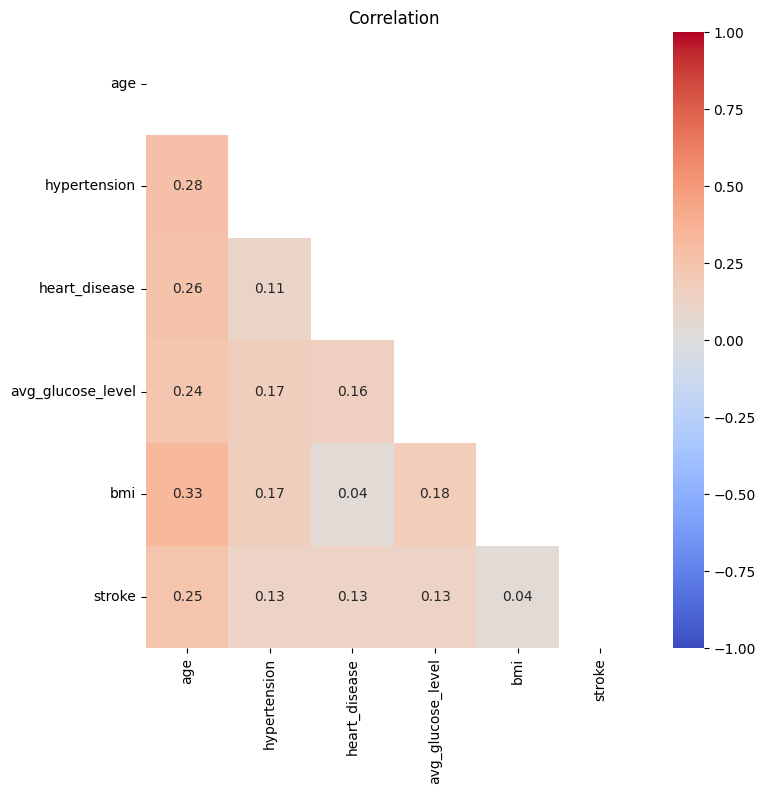

In [19]:
soml.pd.plot.correlation(dataframe=all_data, numeric_only=True, figsize=(8, 8))

# Visualize correlation between categorical features

In [63]:
soml.pd.dataframe.convert_column_to_type(dataframe=all_data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], dtype='category', inplace=True)

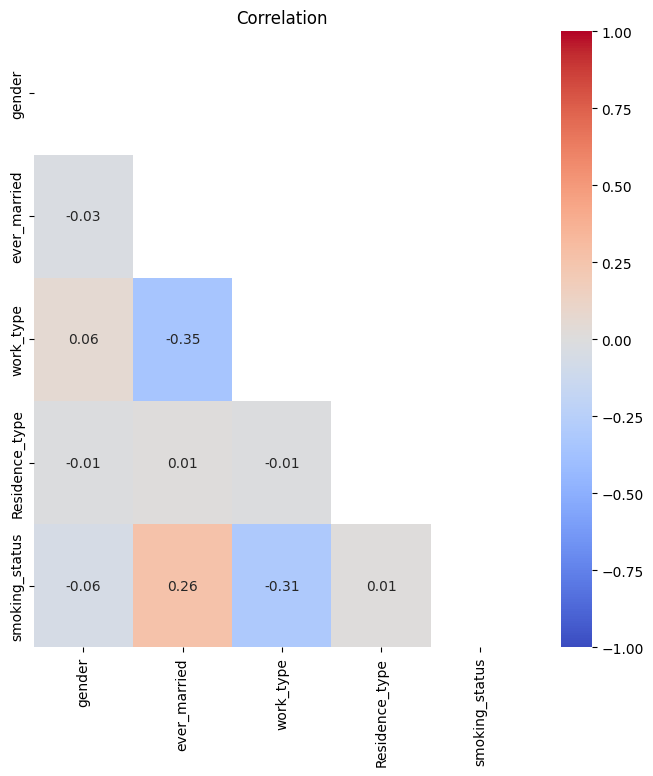

In [66]:
soml.pd.plot.correlation_categorical(all_data, figsize=(8, 8))

# Check the categorical columns vs the label

See if there any features that stand out.

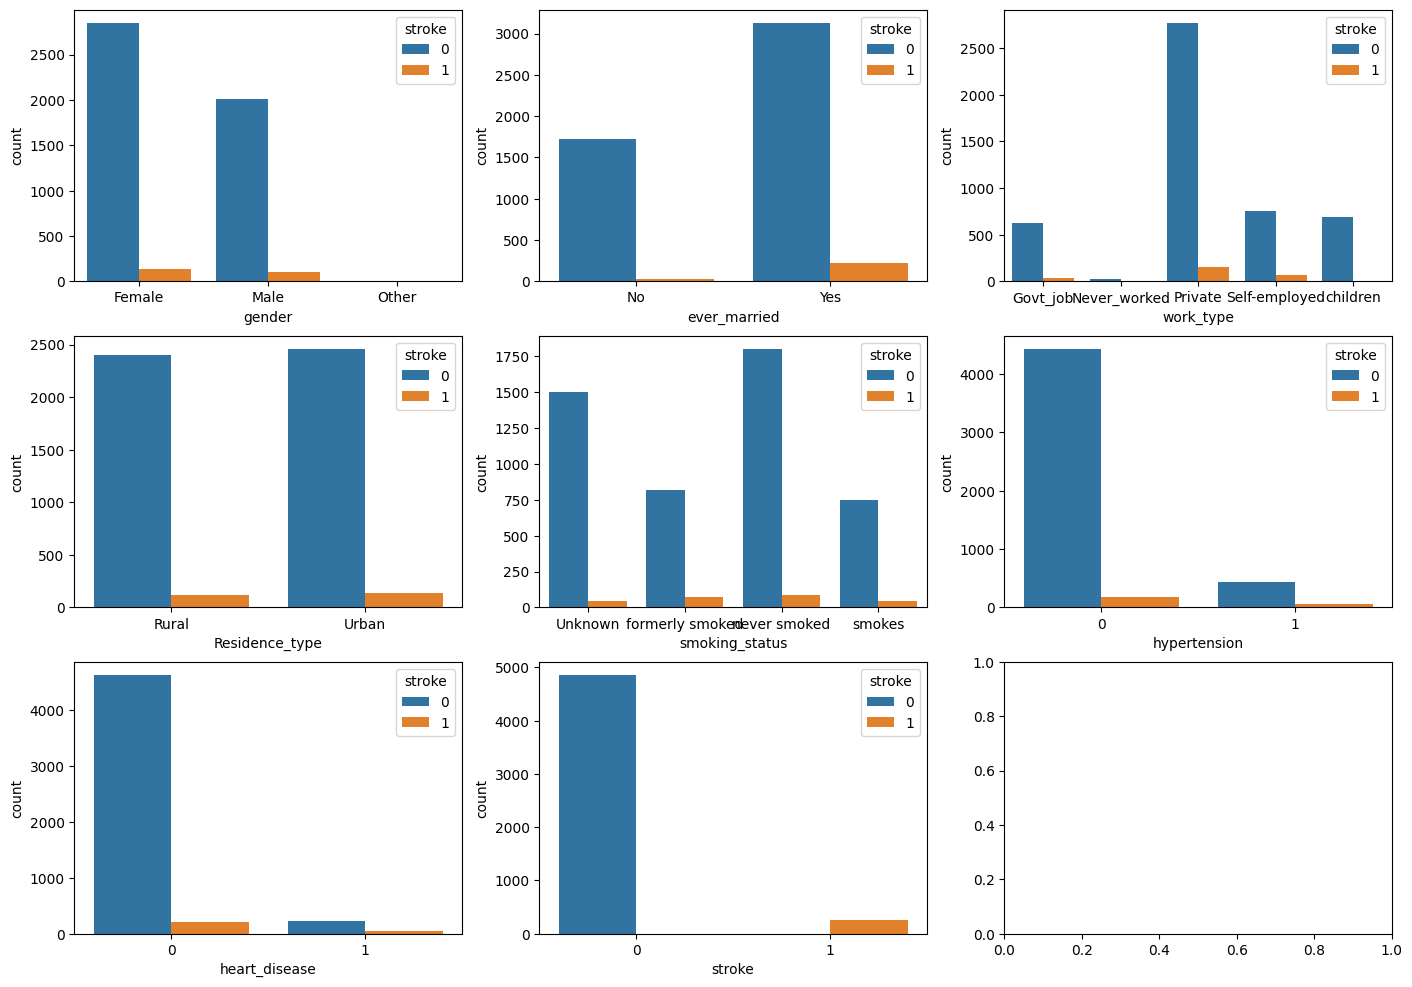

In [27]:
soml.pd.plot.count_categories(dataframe=all_data, label_column='stroke', column_names=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension' ,'heart_disease', 'stroke'])

# Histograms

These might give you insight in the distribution of the data for each feature, are there any outliers that are strange.

Column 'gender' is not visualized, the number of nunique values (3) either exceeds 50 or is lower then 0 or the values are not numeric.
Column 'ever_married' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 0 or the values are not numeric.
Column 'work_type' is not visualized, the number of nunique values (5) either exceeds 50 or is lower then 0 or the values are not numeric.
Column 'Residence_type' is not visualized, the number of nunique values (2) either exceeds 50 or is lower then 0 or the values are not numeric.
Column 'smoking_status' is not visualized, the number of nunique values (4) either exceeds 50 or is lower then 0 or the values are not numeric.


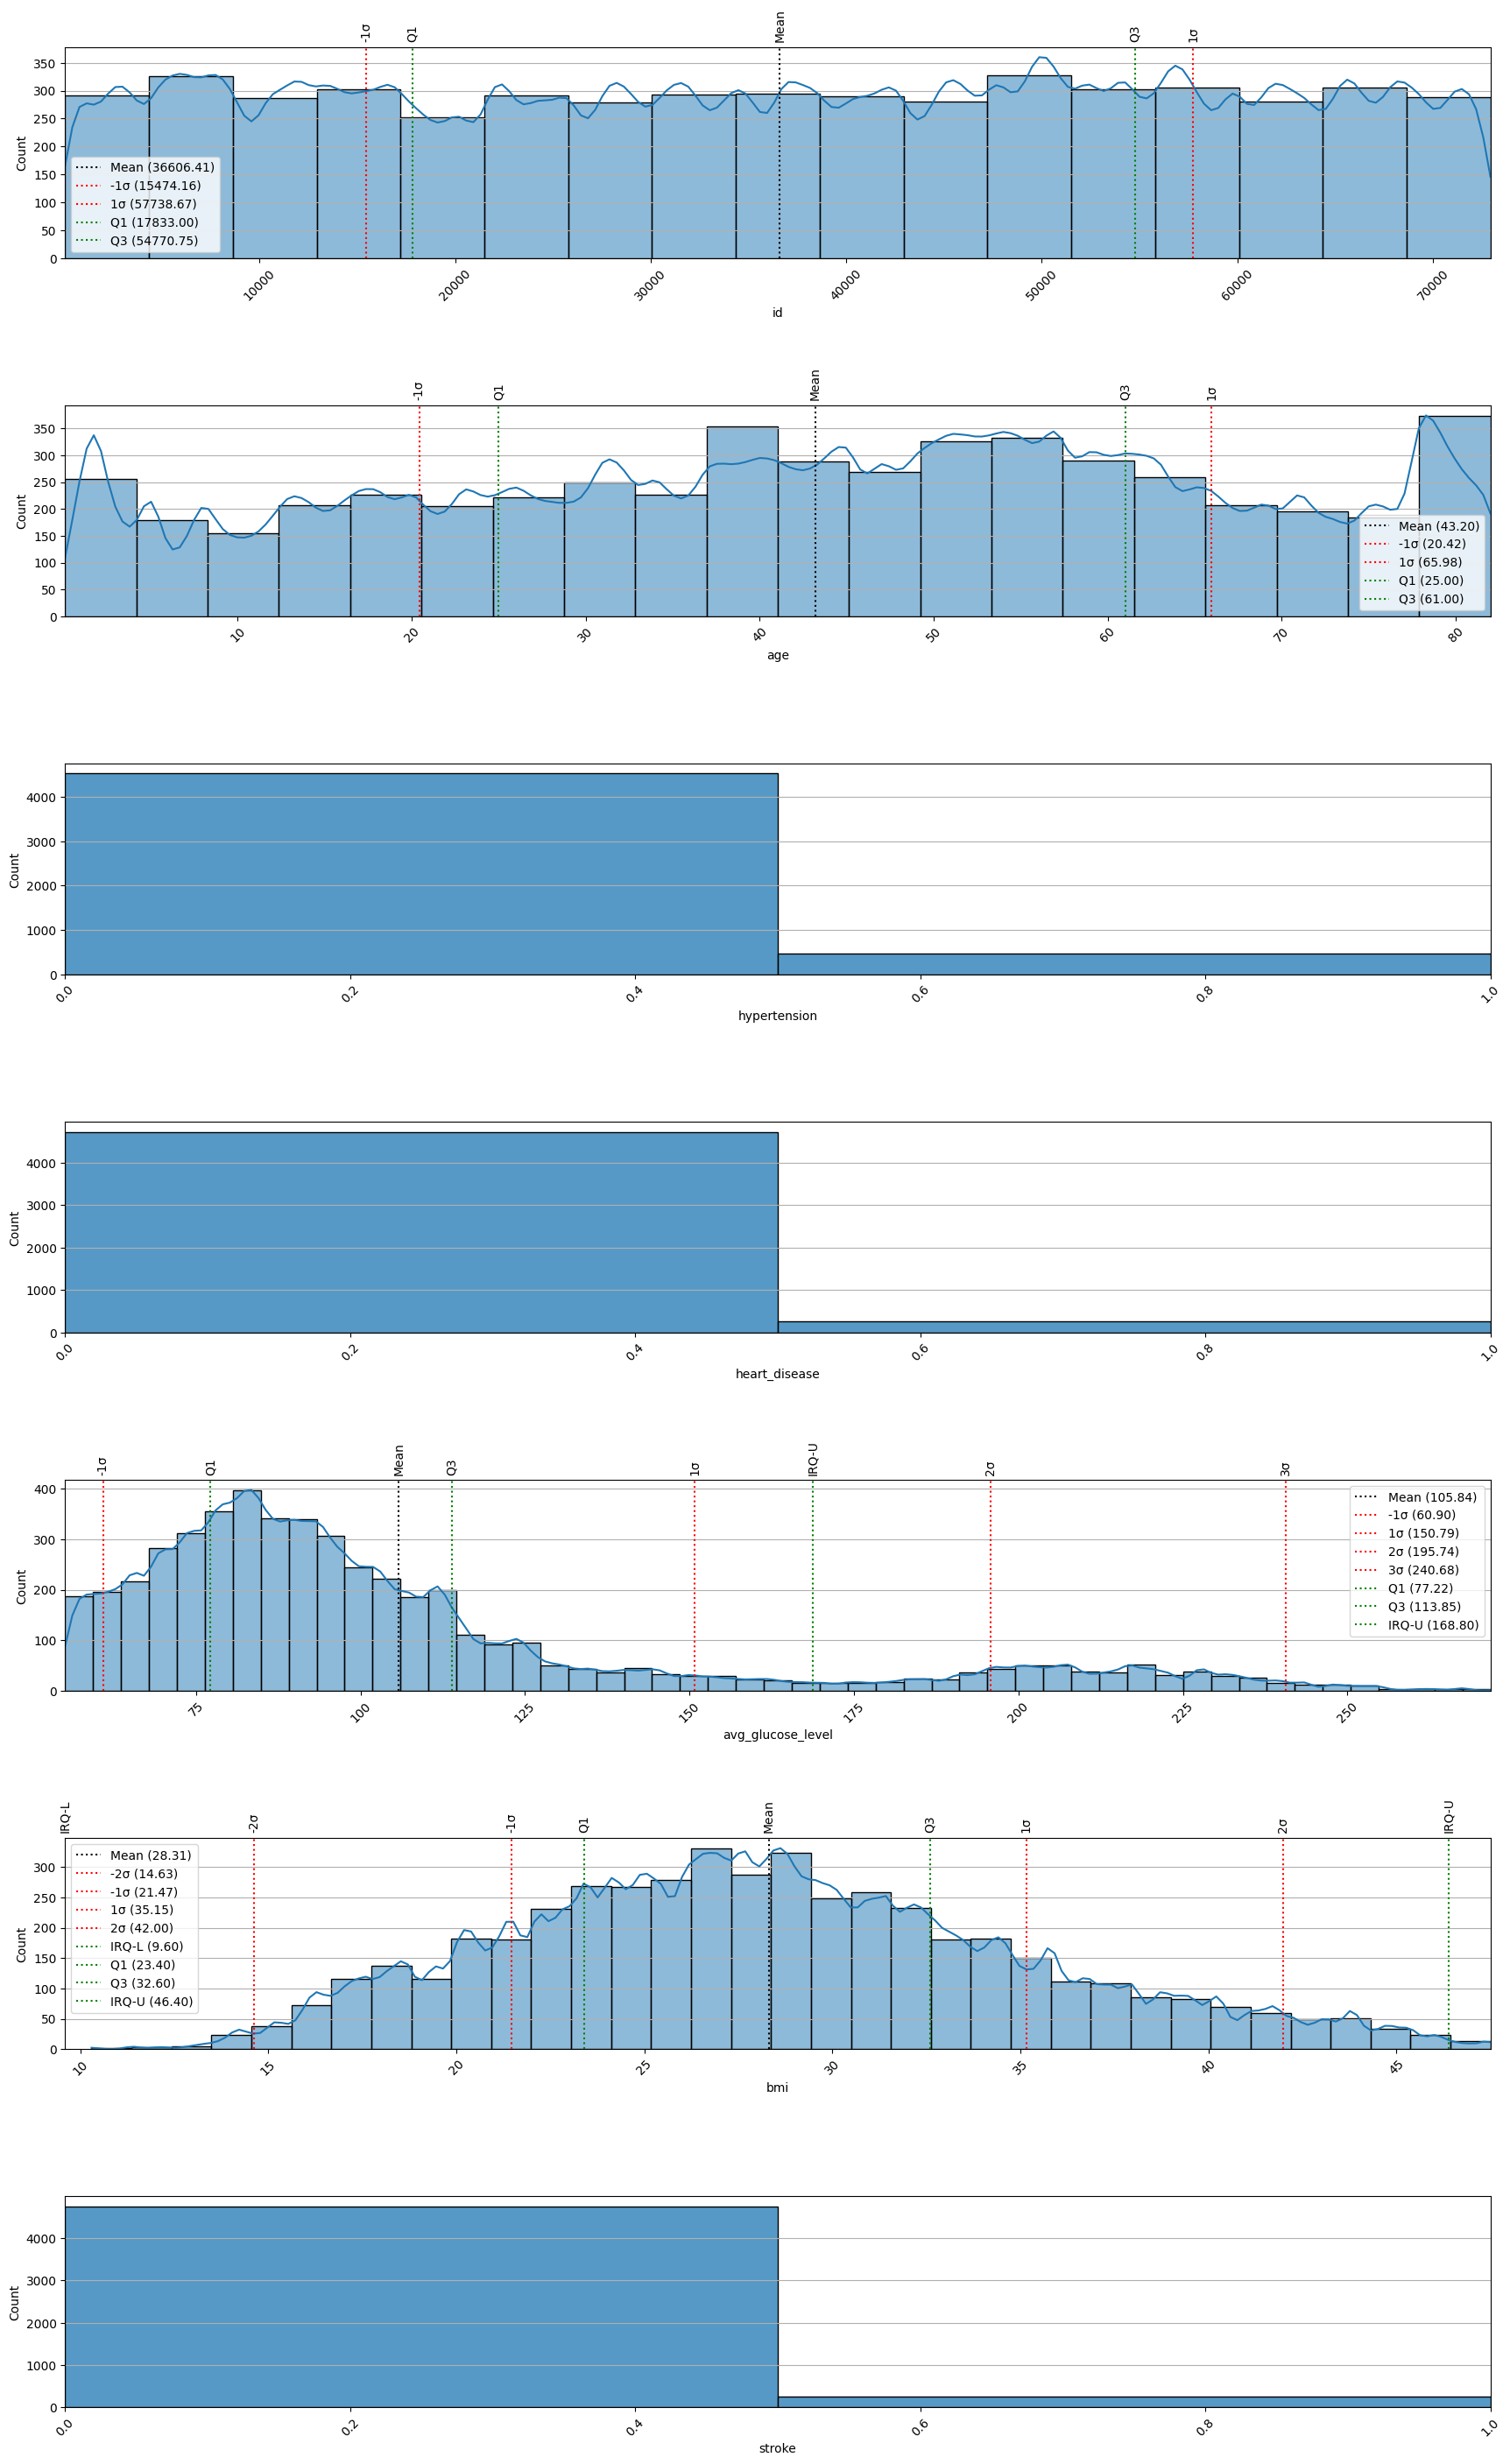

In [211]:
soml.pd.plot.histogram_for_columns(dataframe=all_data)

# Create a profile report

                                             |                | [  0%]   00:00 -> (? left)


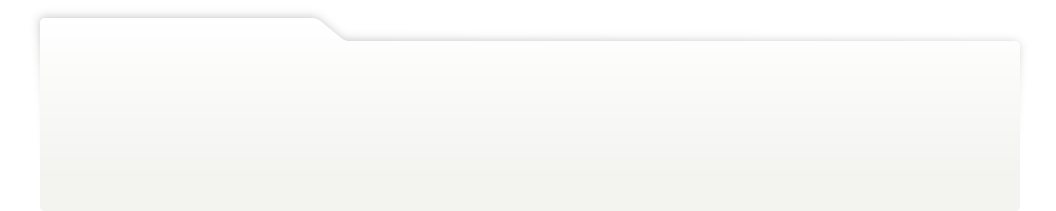
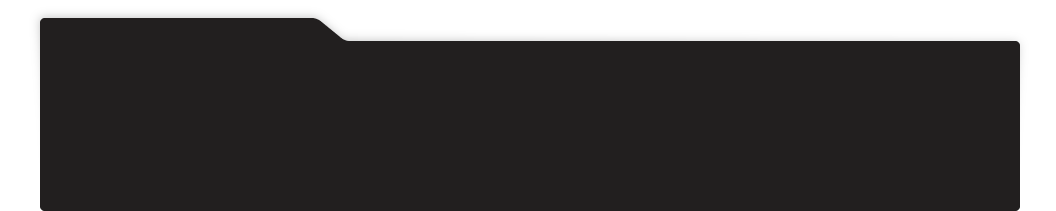
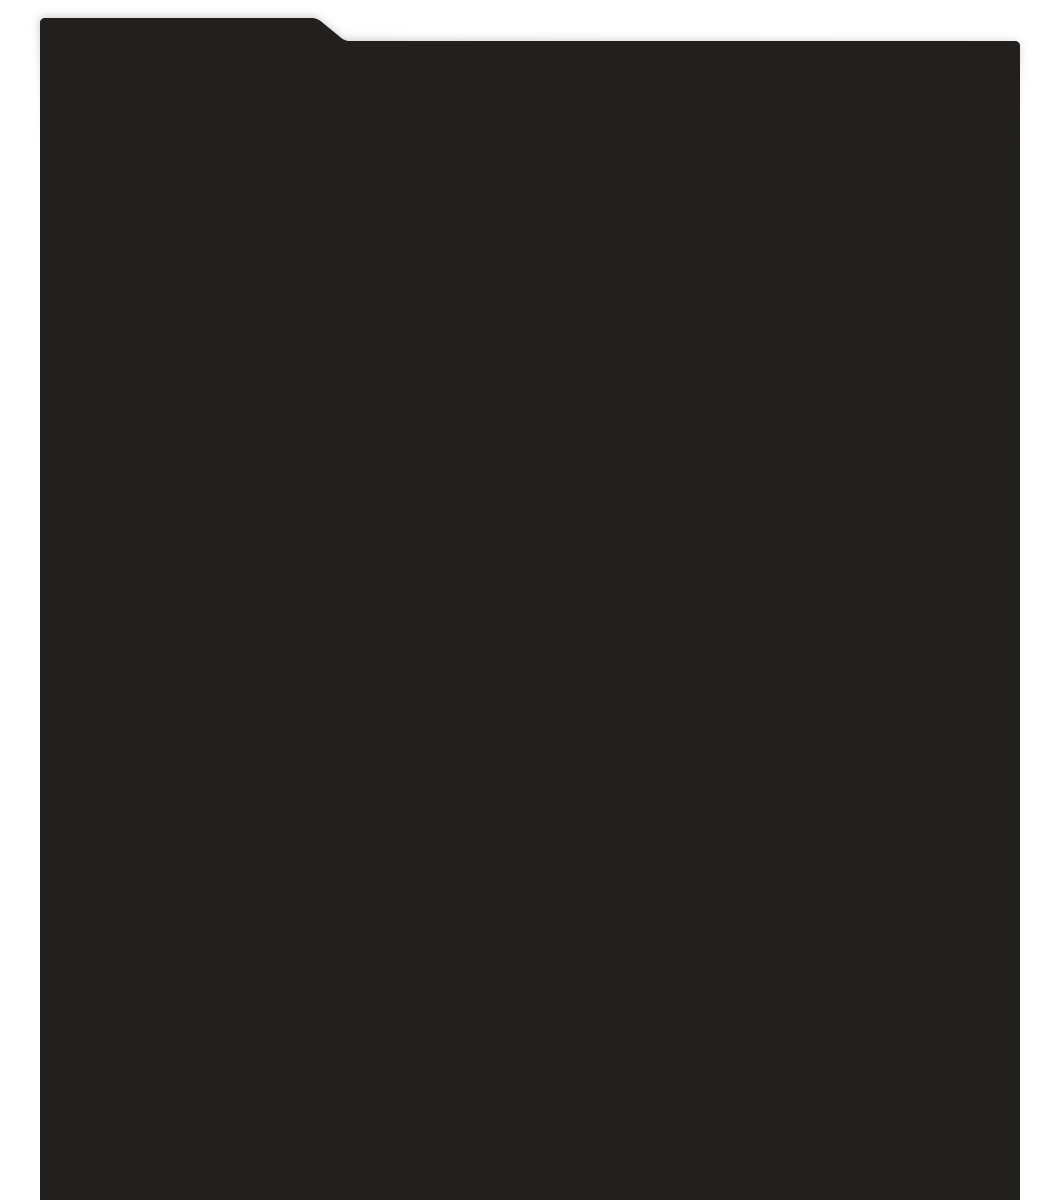
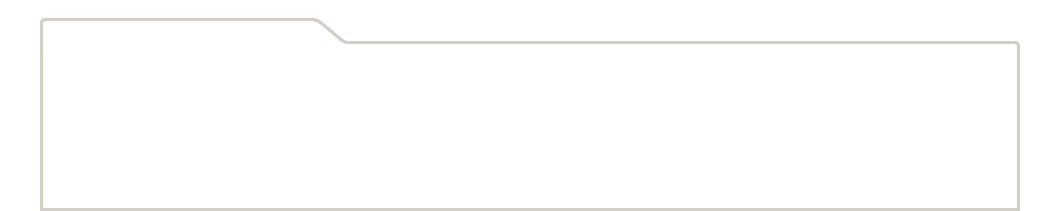
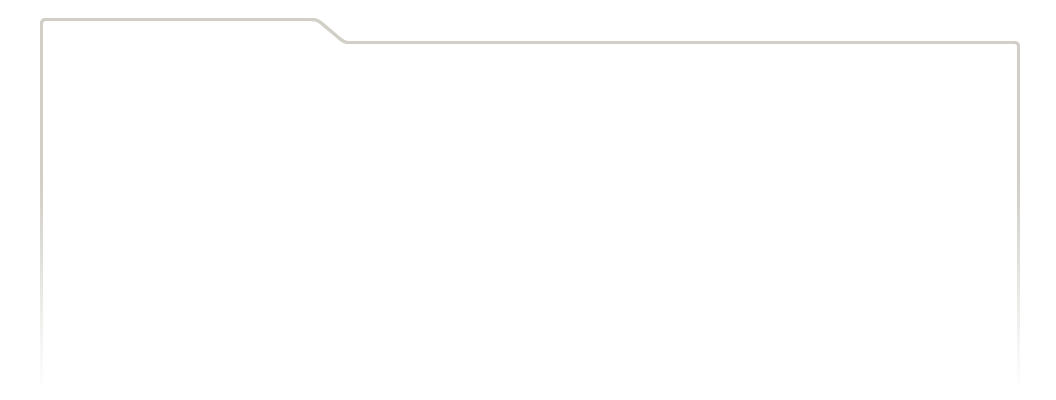
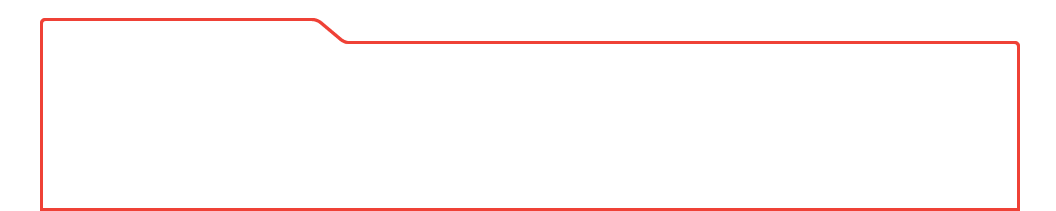
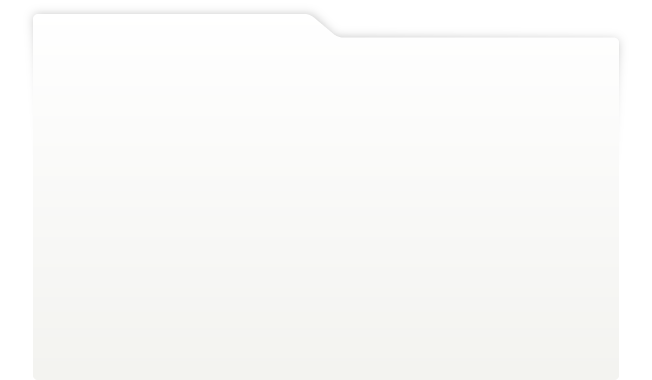
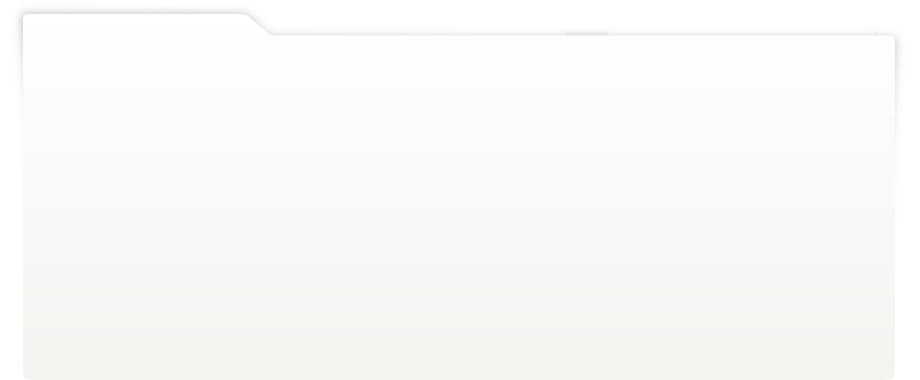
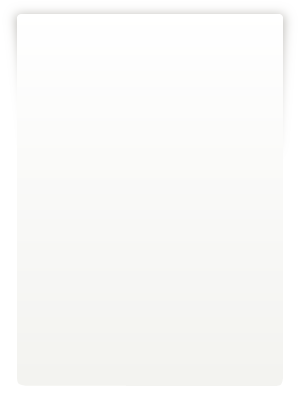
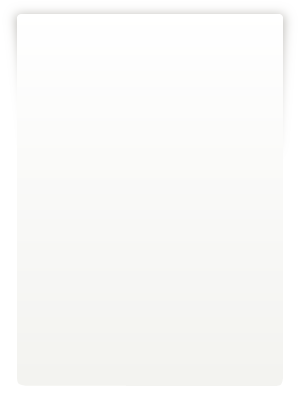
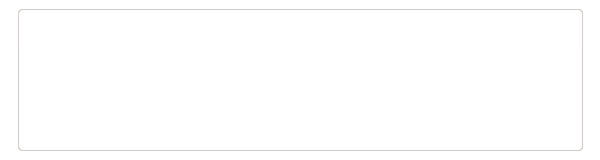
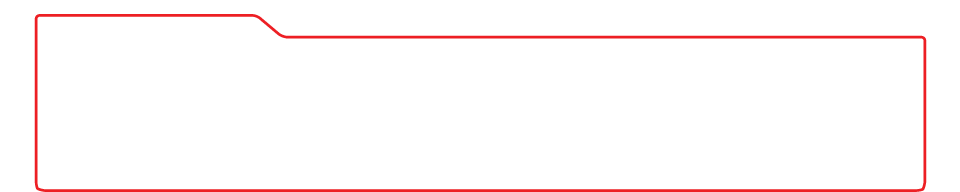
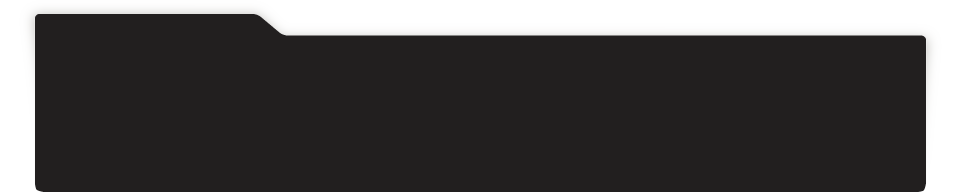
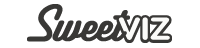
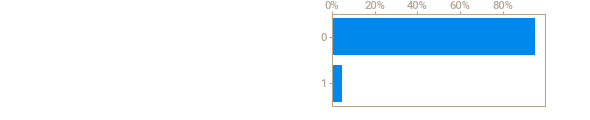
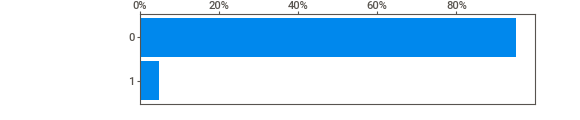
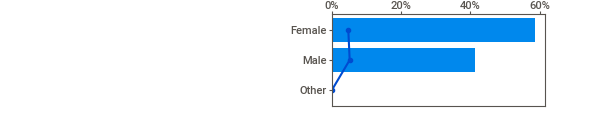
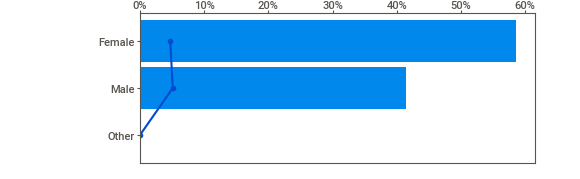
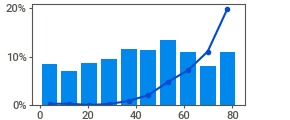
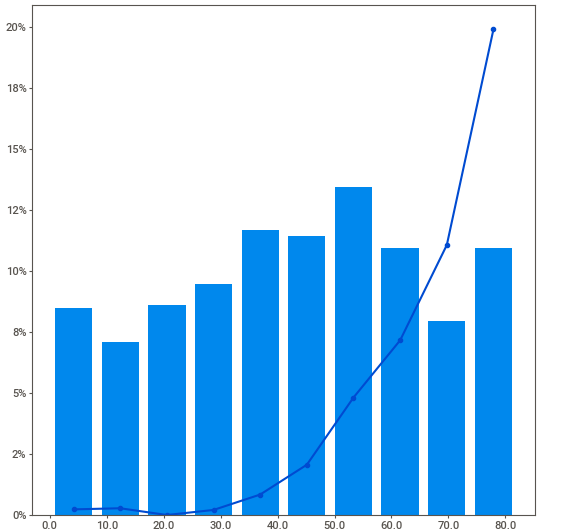
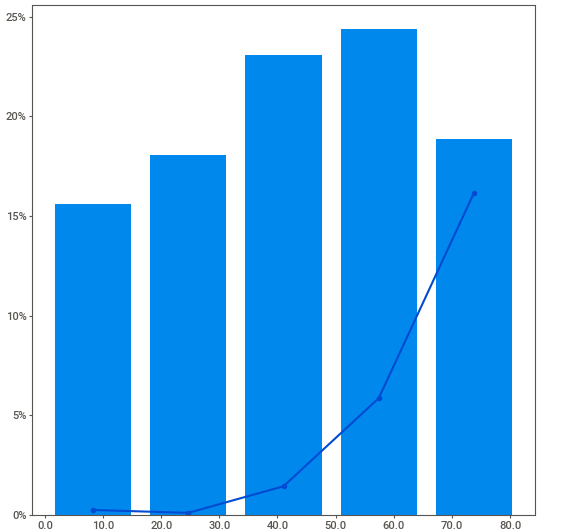
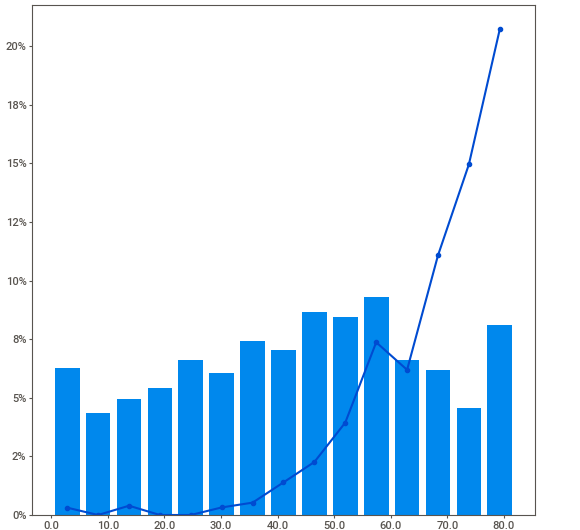
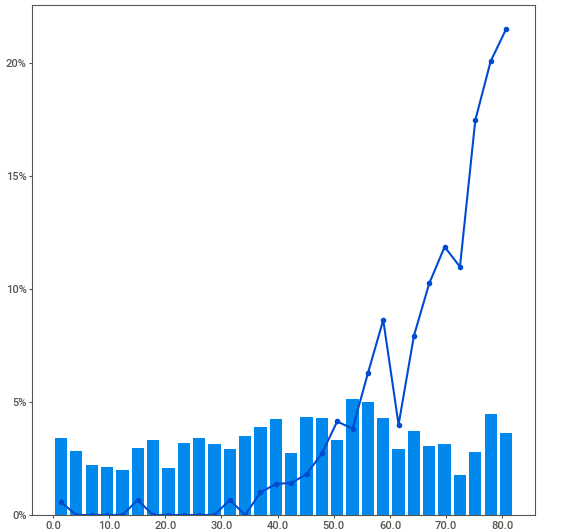
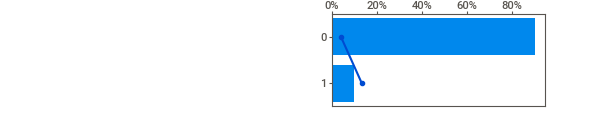
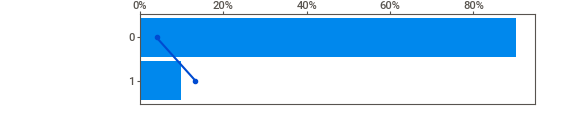
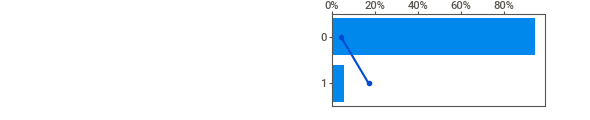
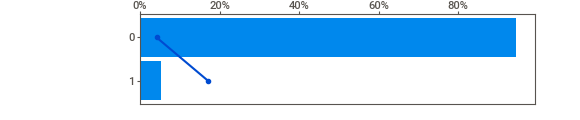
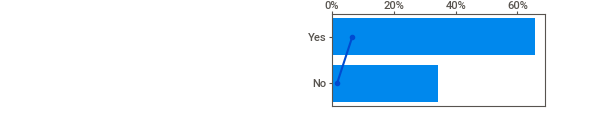
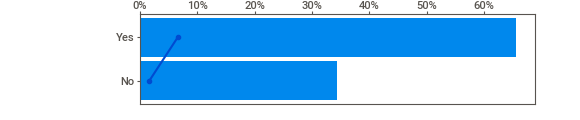
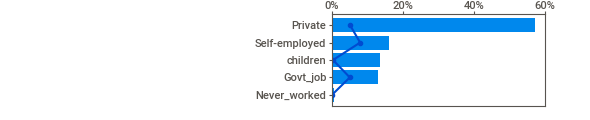
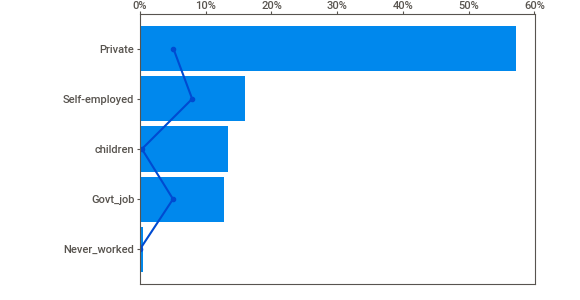
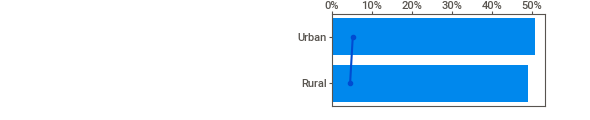
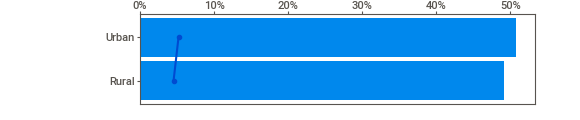
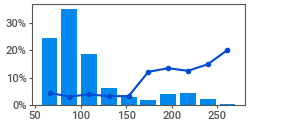
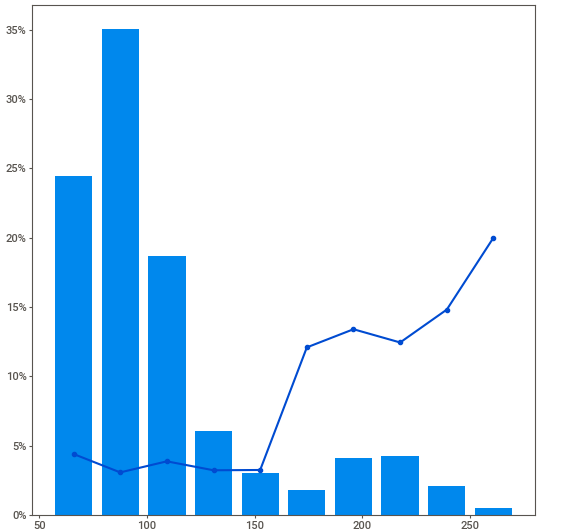
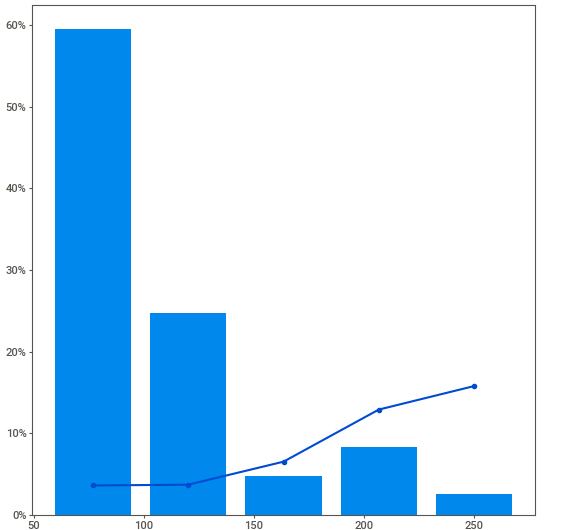
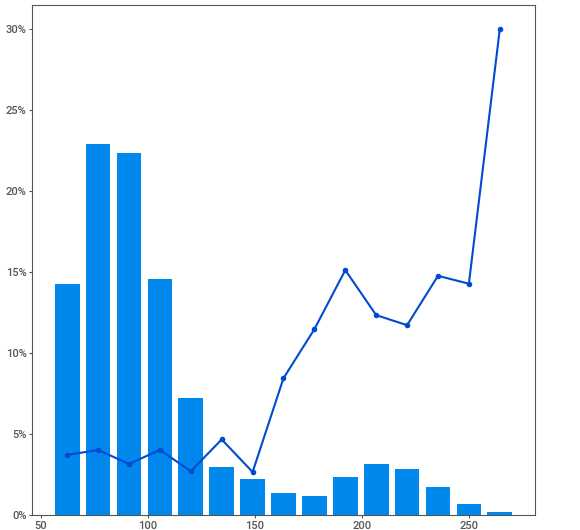
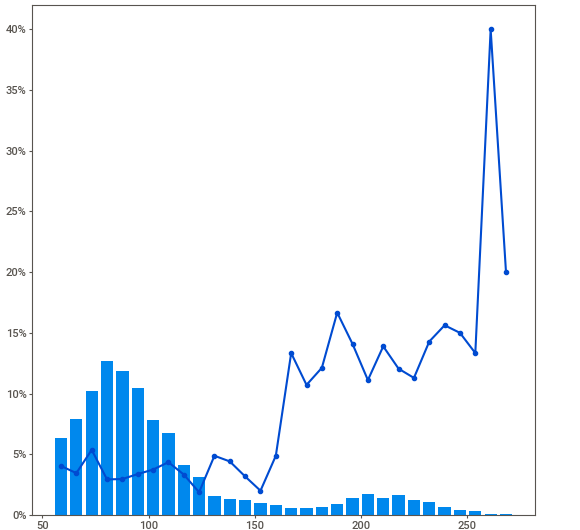
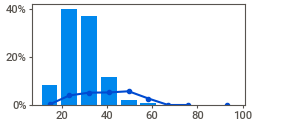
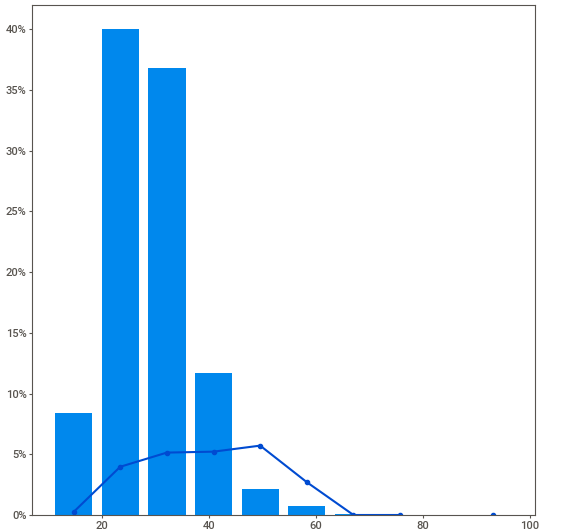
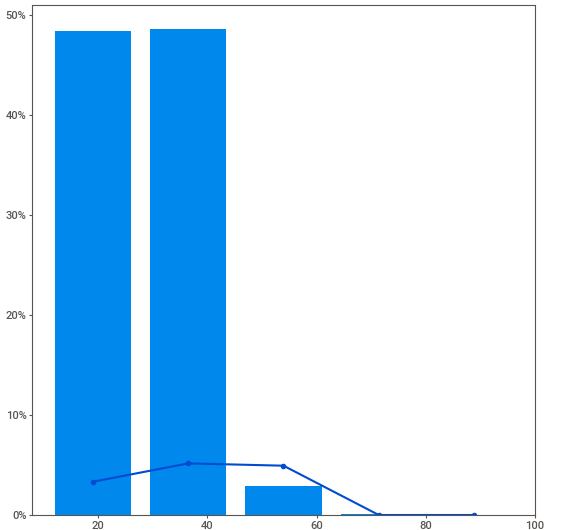
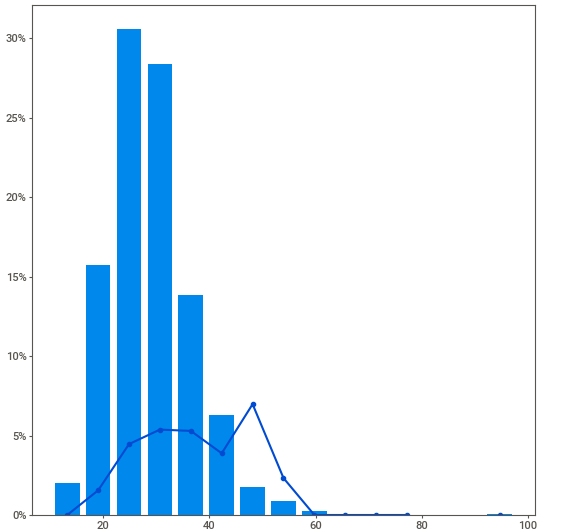
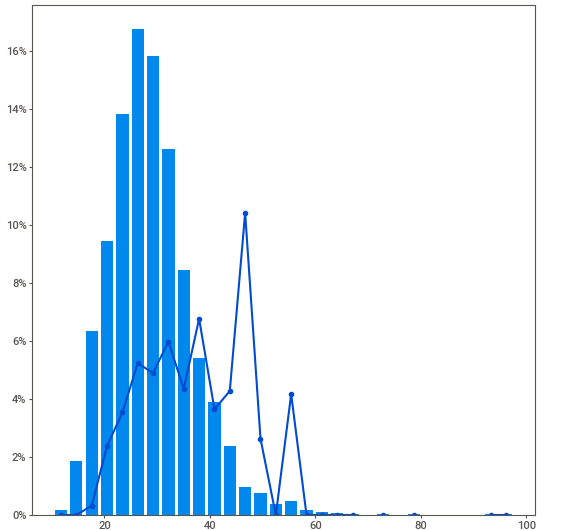
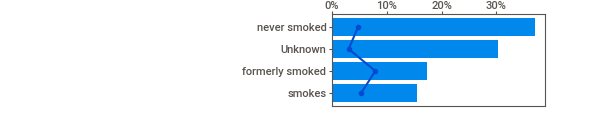
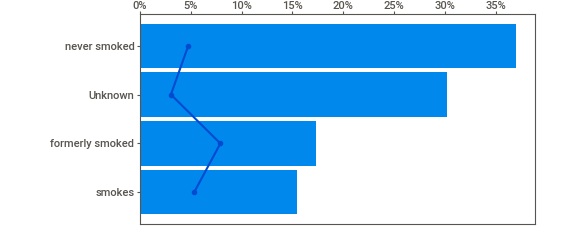
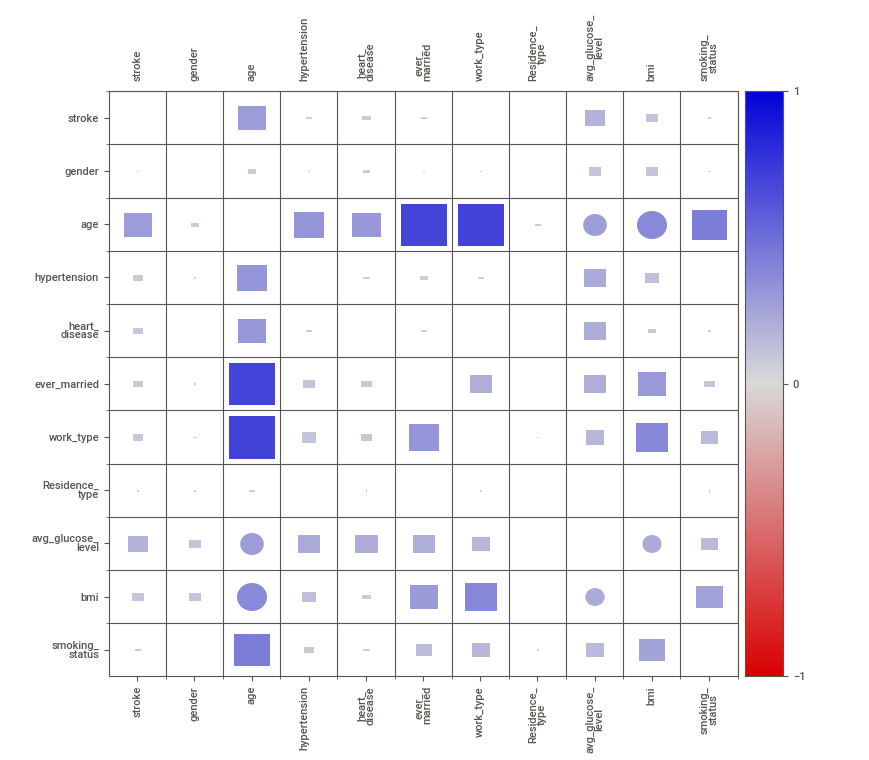
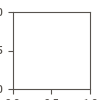

In [9]:
my_report = sv.analyze(all_data, target_feat='stroke')
my_report.show_notebook(layout='widescreen', h='full')

# Handle outliers

Outliers might skew the data (data is clustered more to the left or right), this can have a negative impact on the performance of the model.

In [27]:
soml.pd.dataframe.describe(dataframe=all_data)

,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max,IRQ-L,IRQ,IRQ-U
0,gender,object,5110,0,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,age,float64,5110,0,104,43.23,22.61,-24.61,111.06,0.08,25.00,45.00,61.00,82.00,-29.00,36.00,115.00
2,hypertension,int64,5110,0,2,0.10,0.30,-0.79,0.99,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,heart_disease,int64,5110,0,2,0.05,0.23,-0.62,0.73,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,ever_married,object,5110,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,work_type,object,5110,0,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,Residence_type,object,5110,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,avg_glucose_level,float64,5110,0,3979,106.15,45.28,-29.70,242.00,55.12,77.25,91.88,114.09,271.74,21.98,36.84,169.36
8,bmi,float64,4909,201,418,28.89,7.85,5.33,52.46,10.30,23.50,28.10,33.10,97.60,9.10,9.60,47.50
9,smoking_status,object,5110,0,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [39]:
soml.pd.dataframe.delete_rows_where_value_larger_then(dataframe=all_data, column_name='bmi', value=47.50, inplace=True)
soml.pd.dataframe.delete_rows_where_value_equal_to(dataframe=all_data, column_name='gender', value='Other', inplace=True)
soml.pd.dataframe.delete_rows_where_value_larger_then(dataframe=all_data, column_name='avg_glucose_level', value=242, inplace=True)

In [40]:
soml.pd.dataframe.describe(dataframe=all_data)

,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max,IRQ-L,IRQ,IRQ-U
0,id,int64,4950,0,4950,36558.26,21137.46,-26854.13,99970.65,67.00,17741.25,36952.00,54725.50,72940.00,-37735.12,36984.25,110201.88
1,gender,object,4950,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,age,float64,4950,0,104,42.99,22.75,-25.25,111.22,0.08,25.00,44.00,61.00,82.00,-29.00,36.00,115.00
3,hypertension,int64,4950,0,2,0.09,0.29,-0.78,0.97,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,heart_disease,int64,4950,0,2,0.05,0.23,-0.62,0.73,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
5,ever_married,object,4950,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,work_type,object,4950,0,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,Residence_type,object,4950,0,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,avg_glucose_level,float64,4950,0,3855,104.39,42.74,-23.83,232.61,55.12,77.05,91.55,112.82,240.86,23.38,35.77,166.48
9,bmi,float64,4752,198,344,28.28,6.84,7.78,48.79,10.30,23.40,27.80,32.60,47.50,9.60,9.20,46.40


# Pre-process data

In [30]:
import sklearn as sk

bmi_pipeline = sk.pipeline.Pipeline([
    ("imputer", sk.impute.KNNImputer()),
    ("scaler", sk.preprocessing.StandardScaler())
])

# Set the output to standard, pandas cannot be used in case there is sparse data.
sk.set_config(transform_output='default')
ct = sk.compose.ColumnTransformer(transformers=[
    ('gender', sk.preprocessing.OneHotEncoder(categories=[[
        'Female', 
        'Male']], sparse_output=True), ['gender']),
    ("age", sk.preprocessing.StandardScaler(), ['age']),
    ("married", soml.sklearn.encoder.BooleanEncoder(value_zero='No', value_one='Yes'), ["ever_married"]),
    ("work", sk.preprocessing.OneHotEncoder(categories=[[
        'Never_worked',
        'children',
        'Govt_job',
        'Private',
        'Self-employed',
        ]], sparse_output=True), ['work_type']),
    ("residence", sk.preprocessing.OneHotEncoder(categories=[[
        'Urban',
        'Rural']], sparse_output=True), ['Residence_type']),
    ("glucose", sk.preprocessing.StandardScaler(), ['avg_glucose_level']),
    ("smoking", sk.preprocessing.OneHotEncoder(categories=[[
        'Unknown',
        'never smoked',
        'formerly smoked',
        'smokes']], sparse_output=True), ['smoking_status']),
    ("bmi", bmi_pipeline, ['bmi'])],
    verbose_feature_names_out=True,
    remainder='passthrough'
)

ct.fit(all_data)

ColumnTransformer(remainder='passthrough',
                  transformers=[('gender',
                                 OneHotEncoder(categories=[['Female', 'Male']]),
                                 ['gender']),
                                ('age', StandardScaler(), ['age']),
                                ('married',
                                 BooleanEncoder(value_one='Yes',
                                                value_zero='No'),
                                 ['ever_married']),
                                ('work',
                                 OneHotEncoder(categories=[['Never_worked',
                                                            'children',
                                                            'Govt_job',
                                                            'Private',
                                                            'Self-employed']]),
                                 ['work_type']),
                                ('residence',
                                 OneHotEncoder(categories=[['Urban', 'Rural']]),
                                 ['Residence_type']),
                                ('glucose', StandardScaler(),
                                 ['avg_glucose_level']),
                                ('smoking',
                                 OneHotEncoder(categories=[['Unknown',
                                                            'never smoked',
                                                            'formerly smoked',
                                                            'smokes']]),
                                 ['smoking_status']),
                                ('bmi',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['bmi'])])

In [31]:
result = ct.transform(all_data)
result_pd = pd.DataFrame(result, columns=ct.get_feature_names_out())
soml.pd.dataframe.describe(result_pd)

,Column,DType,NotNull,Null,Unique,Mean,Std,-3σ,3σ,Min,25%,50%,75%,Max,IRQ-L,IRQ,IRQ-U
0,gender__gender_Female,float64,4950,0,2,0.58,0.49,-0.90,2.06,0.00,0.00,1.00,1.00,1.00,-1.50,1.00,2.50
1,gender__gender_Male,float64,4950,0,2,0.42,0.49,-1.06,1.90,0.00,0.00,0.00,1.00,1.00,-1.50,1.00,2.50
2,age__age,float64,4950,0,104,-0.00,1.00,-3.00,3.00,-1.89,-0.79,0.04,0.79,1.72,-3.17,1.58,3.17
3,married__ever_married,float64,4950,0,2,0.65,0.48,-0.78,2.08,0.00,0.00,1.00,1.00,1.00,-1.50,1.00,2.50
4,work__work_type_Never_worked,float64,4950,0,2,0.00,0.07,-0.20,0.20,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
5,work__work_type_children,float64,4950,0,2,0.14,0.35,-0.90,1.18,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
6,work__work_type_Govt_job,float64,4950,0,2,0.13,0.33,-0.87,1.13,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
7,work__work_type_Private,float64,4950,0,2,0.57,0.50,-0.92,2.06,0.00,0.00,1.00,1.00,1.00,-1.50,1.00,2.50
8,work__work_type_Self-employed,float64,4950,0,2,0.16,0.37,-0.94,1.26,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9,residence__Residence_type_Urban,float64,4950,0,2,0.51,0.50,-0.99,2.01,0.00,0.00,1.00,1.00,1.00,-1.50,1.00,2.50


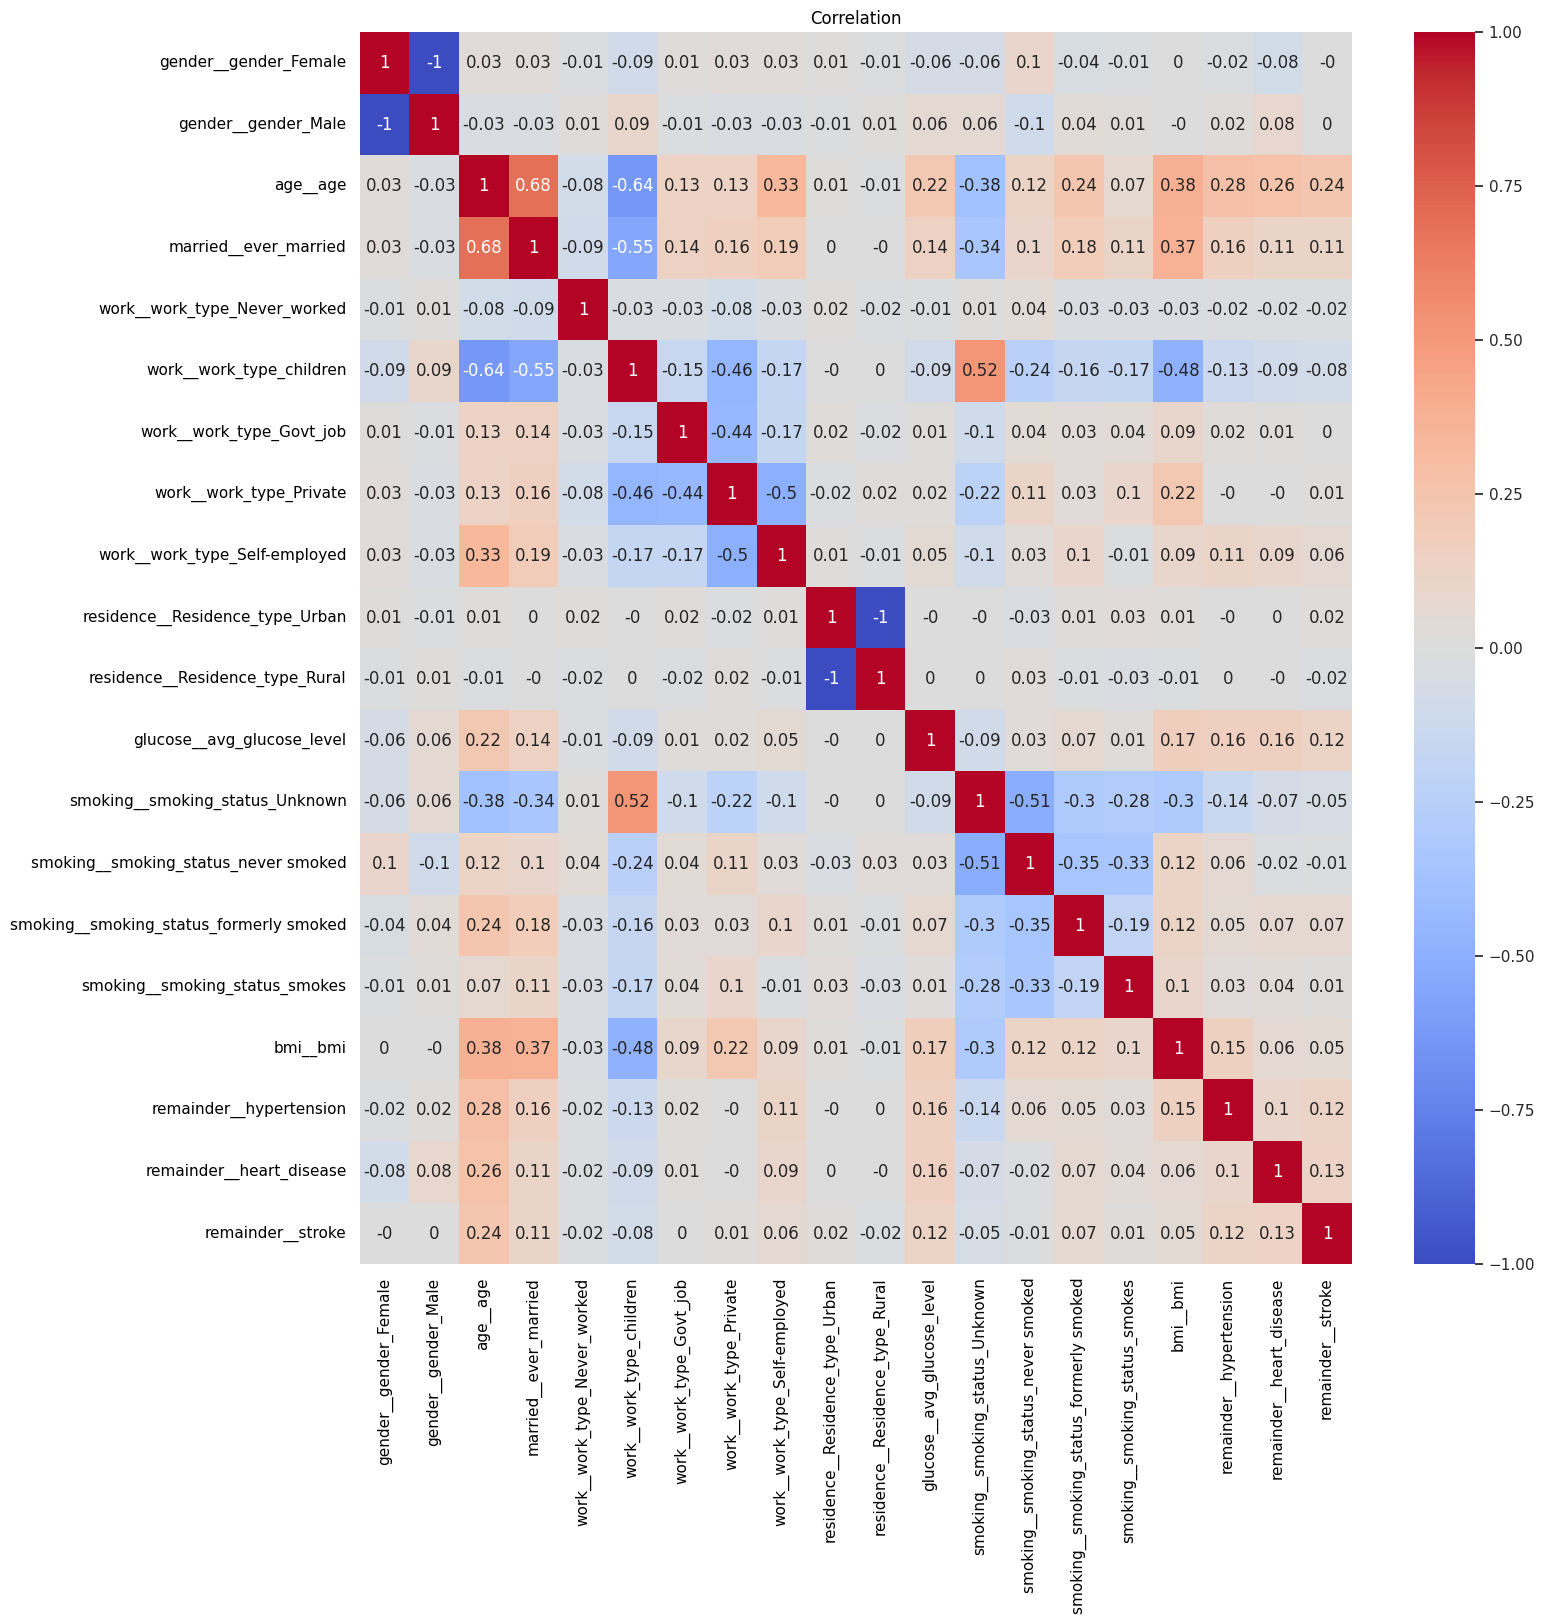

In [61]:
soml.pd.plot.correlation(dataframe=result_pd, numeric_only=True, figsize=(16, 16))

# Split data into train / test

In [15]:
train_x, test_x = soml.data.split.split_train_test_data(result_pd)
len(train_x), len(test_x)

(3960, 990)

# Use SMOTE Upsampling on the minority class

In [16]:
train_x_s = soml.imblearn.smote.resample(dataframe=train_x, label_column='remainder__stroke', sampling_strategy='minority')
#oversample_to = train_x['remainder__stroke'].count()
#train_x_s = soml.pd.dataframe.simple_oversample(dataframe=train_x, label_column='remainder__stroke', value_to_oversample=1, oversample_to=oversample_to)

In [17]:
train_x_s.shape

(7560, 20)

# Split features / Labels

In [18]:
train_y_s = soml.pd.dataframe.column_as_dataframe(dataframe=train_x_s, column_name='remainder__stroke', drop_after=True)
test_y = soml.pd.dataframe.column_as_dataframe(dataframe=test_x, column_name='remainder__stroke', drop_after=True)

len(train_y_s), len(test_y)

(7560, 990)

# Feature Importance

In [19]:
soml.feature_selection.select_k_best.mutual_information_classification(X=train_x_s, y=train_y_s)

,Score
age__age,0.535971
bmi__bmi,0.451483
married__ever_married,0.122098
smoking__smoking_status_Unknown,0.069188
remainder__hypertension,0.063269
smoking__smoking_status_never smoked,0.057640
remainder__heart_disease,0.057490
work__work_type_Private,0.056363
glucose__avg_glucose_level,0.055694
smoking__smoking_status_smokes,0.054654


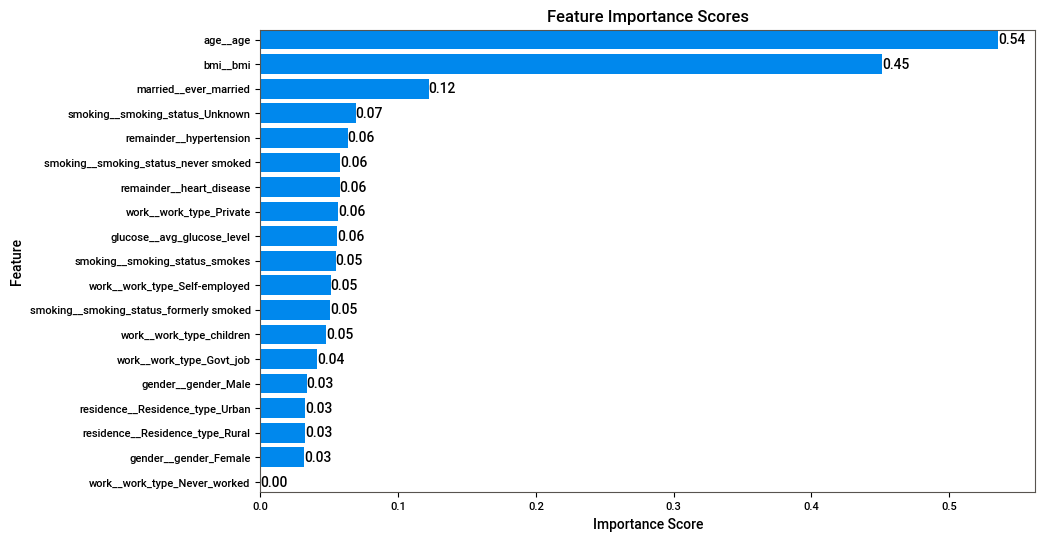

In [20]:
soml.feature_selection.select_k_best.mutual_information_classification_plot(X=train_x_s, y=train_y_s)

In [21]:
# soml.pd.dataframe.drop_columns(dataframe=train_x_s, column_names=['gender__gender_Other', 'gender__gender_Female', 'gender__gender_Male', 'work__work_type_Never_worked'])
# soml.pd.dataframe.drop_columns(dataframe=test_x, column_names=['gender__gender_Other', 'gender__gender_Female', 'gender__gender_Male', 'work__work_type_Never_worked'])

# Create a base model

In [22]:
l2_lambda = 0.00

np.random.seed(42)
tf.random.set_seed(42)

he_initialization = ks.initializers.HeNormal(seed=42);
l2_regularization = ks.regularizers.L2(l2=l2_lambda)

input_layer = ks.layers.Input(shape=(train_x_s.shape[1]))
x = ks.layers.Dense(units=8, activation="relu", 
                    kernel_initializer=he_initialization, 
                    bias_initializer=he_initialization, 
                    bias_regularizer=l2_regularization,
                    kernel_regularizer=l2_regularization)(input_layer)
x = ks.layers.Dropout(rate=0.10)(x)
x = ks.layers.Dense(units=12, activation="relu", 
                    kernel_initializer=he_initialization, 
                    bias_initializer=he_initialization, 
                    bias_regularizer=l2_regularization,
                    kernel_regularizer=l2_regularization)(x)
x = ks.layers.Dropout(rate=0.10)(x)
x = ks.layers.Dense(units=6, activation="relu", 
                    kernel_initializer=he_initialization, 
                    bias_initializer=he_initialization, 
                    bias_regularizer=l2_regularization,
                    kernel_regularizer=l2_regularization)(x)
x = ks.layers.Dropout(rate=0.10)(x)
x = ks.layers.Dense(units=4, activation="relu", 
                    kernel_initializer=he_initialization, 
                    bias_initializer=he_initialization, 
                    bias_regularizer=l2_regularization,
                    kernel_regularizer=l2_regularization)(x)
output_layer = ks.layers.Dense(units=1, activation="sigmoid")(x)

base_model = ks.Model(input_layer, output_layer)
base_model.compile(loss=ks.losses.BinaryCrossentropy(),
                   optimizer=ks.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

In [23]:
soml.tf.model.inspect.list_model(model=base_model)

row   | name (type)            | dtype   | policy  | trainable | output shape | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_1   (InputLayer) | float32 | float32 | True      | [(None, 19)] | 0             | 0                 | 0                    
1     | dense     (Dense     ) | float32 | float32 | True      | (None, 8)    | 160           | 160               | 0                    
2     | dropout   (Dropout   ) | float32 | float32 | True      | (None, 8)    | 0             | 0                 | 0                    
3     | dense_1   (Dense     ) | float32 | float32 | True      | (None, 12)   | 108           | 108               | 0                    
4     | dropout_1 (Dropout   ) | float32 | float32 | True      | (None, 12)   | 0             | 0                 | 0                    
5     | dense_2   (Dense     ) | float32 | float32 | True      | (None, 6)    | 78            | 78                | 0                    
6     | dropout_2 (Dropout   ) | f

In [39]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback()

base_history = base_model.fit(x=train_x_s,
                              y=train_y_s,
                              epochs=80,
                              validation_data=(test_x, test_y),
                              callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback])
                              

Epoch 1/80
237/237 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8120 - val_loss: 0.4254 - val_accuracy: 0.7586 - lr: 2.0000e-04
Epoch 2/80
237/237 [==============================] - 0s 2ms/step - loss: 0.4117 - accuracy: 0.8127 - val_loss: 0.4300 - val_accuracy: 0.7586 - lr: 2.0000e-04
Epoch 3/80
237/237 [==============================] - 0s 2ms/step - loss: 0.4105 - accuracy: 0.8115 - val_loss: 0.4319 - val_accuracy: 0.7596 - lr: 2.0000e-04
Epoch 4/80
237/237 [==============================] - 0s 2ms/step - loss: 0.4053 - accuracy: 0.8155 - val_loss: 0.4296 - val_accuracy: 0.7646 - lr: 2.0000e-04
Epoch 5/80
231/237 [============================>.] - ETA: 0s - loss: 0.4084 - accuracy: 0.8163
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
237/237 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.8164 - val_loss: 0.4298 - val_accuracy: 0.7616 - lr: 2.0000e-04
Epoch 6/80
237/237 [=======================

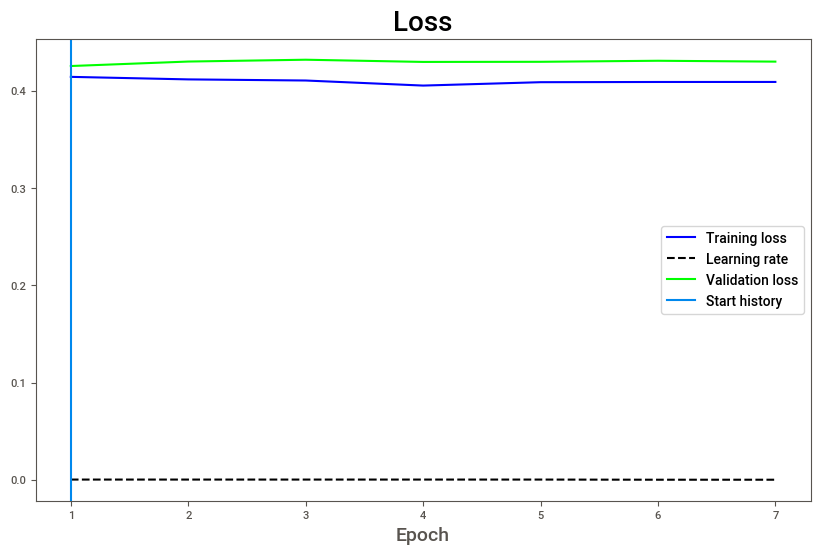

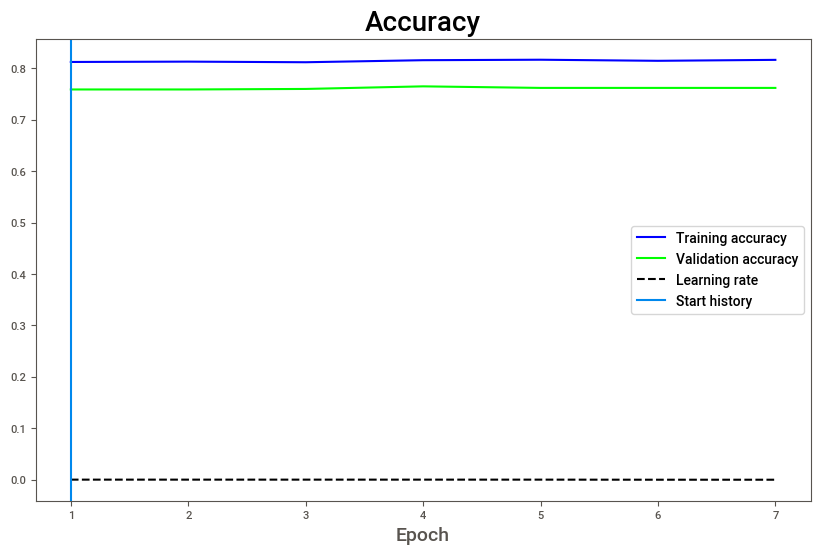

In [40]:
soml.tf.model.plot.plot_history(history=base_history)

In [41]:
y_prob = base_model.predict(test_x)

31/31 [==============================] - 0s 462us/step


In [42]:
test_y.value_counts()

remainder__stroke
0.0                  932
1.0                   58
Name: count, dtype: int64

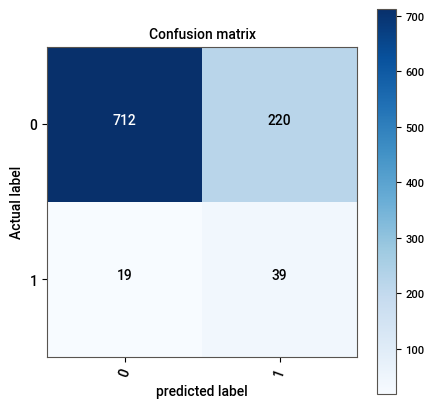

In [43]:
soml.evaluate.plot.confusion_matrix(y_true=test_y, y_prob=y_prob, figsize=(5, 5))

In [34]:
soml.evaluate.analyze.classification_report(y_true=test_y, y_prob=y_prob)

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       932
           1       0.15      0.64      0.24        58

    accuracy                           0.76       990
   macro avg       0.56      0.70      0.55       990
weighted avg       0.92      0.76      0.82       990



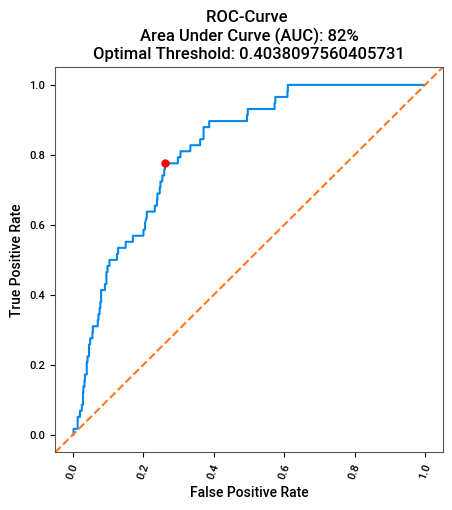

0.40380976

In [35]:
optimal_threshold = soml.evaluate.plot.roc_curve(y_true=test_y, y_prob=y_prob)
optimal_threshold

# Use the optimal threshold to get a more accurate reading 

In [36]:
y_pred_ct = soml.util.label.to_prediction_custom_threshold(y_prob=y_prob, custom_threshold=optimal_threshold)

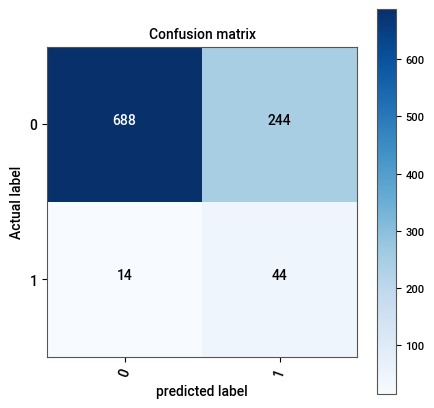

In [37]:
soml.evaluate.plot.confusion_matrix(y_true=test_y, y_pred=y_pred_ct, figsize=(5, 5))

In [38]:
soml.evaluate.analyze.classification_report(y_true=test_y, y_pred=y_pred_ct)

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       932
           1       0.15      0.76      0.25        58

    accuracy                           0.74       990
   macro avg       0.57      0.75      0.55       990
weighted avg       0.93      0.74      0.81       990

